/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
27/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4871 - loss: 2.0402 
Epoch 1: val_accuracy improved from -inf to 0.80435, saving model to best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5369 - loss: 1.8928 - val_accuracy: 0.8043 - val_loss: 1.2543
Epoch 2/1000
30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7476 - loss: 1.4327  
Epoch 2: val_accuracy improved from 0.80435 to 0.84239, saving model to best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7586 - loss: 1.3994 - val_accuracy: 0.8424 - val_loss: 1.1543
Epoch 3/1000
29/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8103 - loss: 1.2140 
Epoch 3: val_accuracy improved from 0.84239 to 0.86413, saving model to best_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8040 - loss: 1.2218 - val_accuracy: 0.8641 - val_loss: 1.0807
Epoch 4/1000
30/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8361 - loss: 1.1053 
Epoch 4: val_accuracy did not improve from

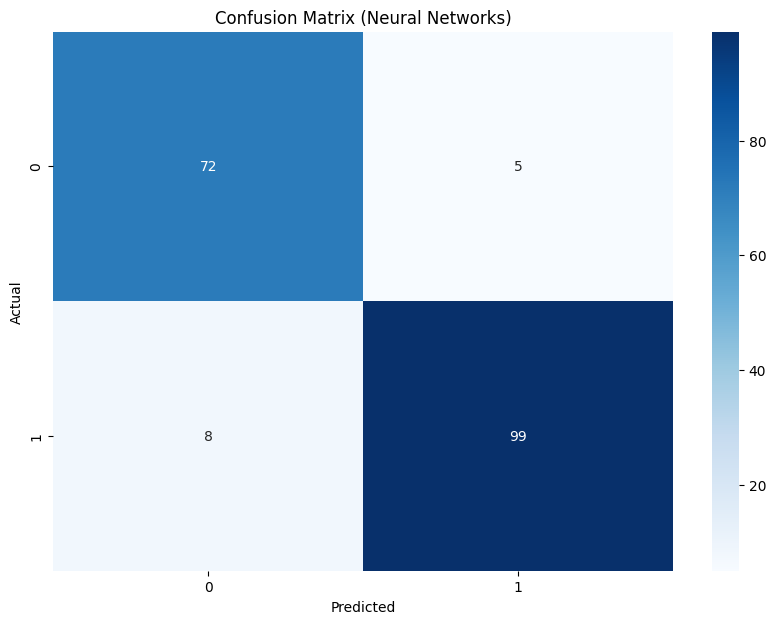

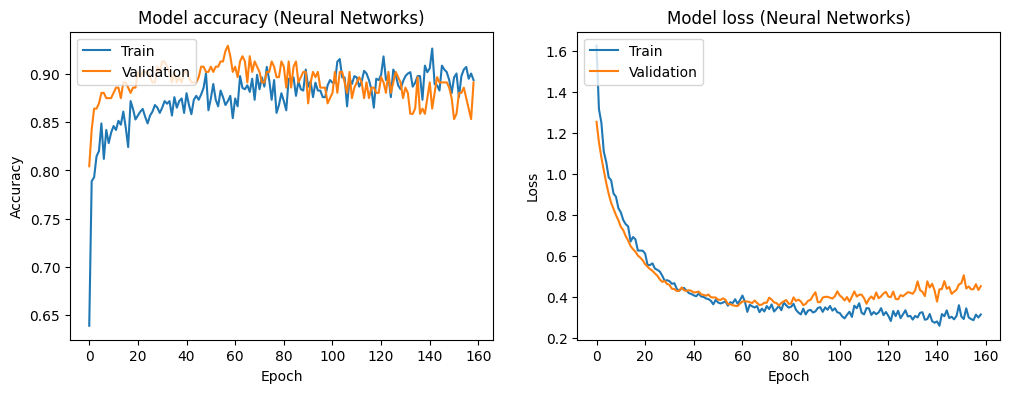

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load the dataset
file_path = 'https://raw.githubusercontent.com/mwardeh-png/Intro-to-ML/main/heart%20(1).csv'  # Change to your actual file path

try:
    # Attempt to read as a CSV
    df = pd.read_csv(file_path)
except pd.errors.ParserError:
    # If reading as CSV fails, attempt to read as Excel
    if file_path.endswith('.xls') or file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path, engine='openpyxl')
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xls file.")

# Encode categorical variables
label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])
df['ChestPainType'] = label_encoder.fit_transform(df['ChestPainType'])
df['RestingECG'] = label_encoder.fit_transform(df['RestingECG'])
df['ExerciseAngina'] = label_encoder.fit_transform(df['ExerciseAngina'])
df['ST_Slope'] = label_encoder.fit_transform(df['ST_Slope'])

# Split the dataset into features and target variable
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Normalize the feature variables
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the target variable to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Define the neural network model
def create_model(hidden_layers=2, layer_size=64, dropout_rate=0.4, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(layer_size, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    for _ in range(hidden_layers - 1):
        model.add(Dense(layer_size, activation='relu', kernel_regularizer='l2'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Custom callback to store the best epoch
class BestEpochCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['val_accuracy'] > self.best_val_accuracy:
            self.best_val_accuracy = logs['val_accuracy']
            self.best_epoch = epoch
    def on_train_begin(self, logs=None):
        self.best_val_accuracy = 0
        self.best_epoch = 0

best_epoch_callback = BestEpochCallback()

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Create and train the model
model = create_model(hidden_layers=2, layer_size=64, dropout_rate=0.4, learning_rate=0.001)
history = model.fit(X_train, y_train, epochs=1000, batch_size=16, validation_data=(X_test, y_test), callbacks=[model_checkpoint, best_epoch_callback, early_stopping])

# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')

# Print the best epoch and validation accuracy
print(f'Best model found at epoch {best_epoch_callback.best_epoch + 1} with validation accuracy {best_epoch_callback.best_val_accuracy:.4f}')

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Best Model Accuracy: {accuracy*100:.2f}%')

# Predict the classes for the test set
y_pred = best_model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Neural Networks)')
plt.show()

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (Neural Networks)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Neural Networks)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()